# 02. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).


## 1. Make classification data ready

we're going to use `sklearn.datasets`, `make_circles`


In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
num_samples = 1000

# Create circles
X, y = make_circles(n_samples=num_samples, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [2]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [3]:
# Make a pd dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


#### Visualize, visualize, visualize

A blog post explaining matplotlib `colormaps`: https://www.deeplearningnerds.com/matplotlib-color-maps/#:~:text=Use%20Colormap%20in%20Scatter%20Plot&text=The%20color%20range%20must%20be,we%20can%20use%20different%20Colormaps.


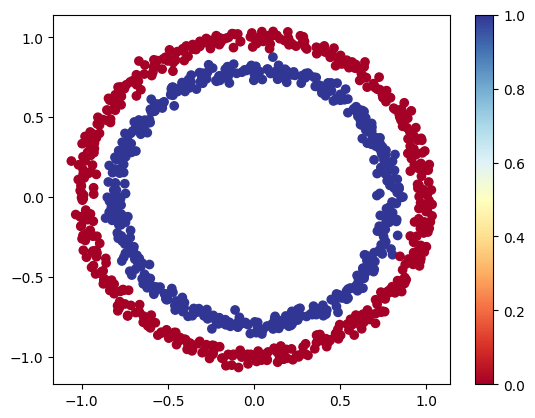

In [4]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.colorbar()
plt.show()

#### Note: The data we're working with is often referred to as a **Toy Dataset**, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

More about scikit-learn generated toy datasets - https://scikit-learn.org/stable/datasets/sample_generators.html

More about the `make_circles` generator we've used - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles

A blog post about different datasets on sk-learn datasets - https://hackernoon.com/16-best-sklearn-datasets-for-building-machine-learning-models


### 1.1 Check input and output shapes


In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [7]:
# Check types and data types
type(X), type(y), X.dtype, y.dtype

(numpy.ndarray, numpy.ndarray, dtype('float64'), dtype('int64'))

Data is in numpy array but we should convert it to PyTorch's tensors, `torch.tensor`


In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Value for one sample of X: {X_sample} and the same for y: {y_sample}")
print(
    f"Shape of one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}"
)

Value for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape of one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits


In [9]:
import torch

torch.__version__

'2.2.1+cpu'

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

type(X), type(y), X.dtype, y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [11]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

#### Spliting data into train and test sets


In [12]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% of the data
    random_state=42,
)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Set up device agnostic code so our code can run on accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop


### 2.1 Device agnostic code


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 2.2 Create model

We'll create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch do so)
2. Create 2 `nn.Linear` layers that are capable of handling the shapes of our data
3. Define a `forward()` method
4. Instantiate an instance of our model class and send it to the target `device`


In [15]:
X_train.shape

torch.Size([800, 2])

In [16]:
from torch import nn

# Model that subclasses nn.Module


class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 nn.Linear layers
        self.layer1 = nn.Linear(
            in_features=2, out_features=5
        )  # Takes in 2 features and upscales to 5
        self.layer2 = nn.Linear(
            in_features=5, out_features=1
        )  # Takes in 5 features from previous layer and outputs 1 feature (same shape as y)

    # Forward pass
    def forward(self, x):
        return self.layer2(self.layer1(x))  # x -> layer1 -> layer2 -> output

#### Instatiate an instance our model class and send it to target device


In [17]:
model_0 = CircleModelV0().to(device=device)
model_0, device

(CircleModelV0(
   (layer1): Linear(in_features=2, out_features=5, bias=True)
   (layer2): Linear(in_features=5, out_features=1, bias=True)
 ),
 'cpu')

We can use [tensorflow playground](https://playground.tensorflow.org) to build, play around and visualize neural networks.


### Let's recreate the model using `nn.Sequential()`

`nn.Sequential()` takes care of most stuff behind the scenes for us, but building the NN class by subclassing from `nn.Module` is prefered when we want more control over the model, like if we want to add more tweaks to the model.


In [18]:
seq_model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), nn.Linear(in_features=5, out_features=1)
).to(device)

seq_model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

The `nn.Sequential()` can also subclass `nn.Module`


In [19]:
class CircleModelVSeq(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining Layers with Sequential
        self.seq_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1),
        )

    # Forward pass
    def forward(self, x):
        return self.seq_layers(x)  # x -> sequential layers -> output

In [20]:
seq_model_1 = CircleModelVSeq().to(device)
seq_model_1

CircleModelVSeq(
  (seq_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [21]:
# Model parameters
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.5260, -0.3113],
                      [ 0.4862,  0.0031],
                      [-0.0868, -0.2918],
                      [ 0.5812, -0.3392],
                      [ 0.1845,  0.4741]])),
             ('layer1.bias',
              tensor([ 0.4227,  0.4428,  0.5113,  0.4388, -0.2288])),
             ('layer2.weight',
              tensor([[-0.3396,  0.3377, -0.1224, -0.3371, -0.2816]])),
             ('layer2.bias', tensor([0.1482]))])

#### Making predictions with untrained model and visualizing the test sets

We should expect gibberish as the model is untrained


In [22]:
with torch.inference_mode():
    untrained_preds = model_0(X_test)

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[ 0.0527],
        [ 0.1282],
        [-0.1049],
        [ 0.0972],
        [-0.0411],
        [ 0.0044],
        [ 0.1663],
        [ 0.1375],
        [-0.1073],
        [ 0.1339]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [23]:
# Test sets
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

Note how the predictions are float dtype, but we want them in binary.


### Setting up a loss function and optimizer

Which Loss Function or Optimizer should you use? ... This is Problem specific

For example, for **regression** you might want Mean Absolute Error(MAE/L1Loss) or Mean Squared Error (MSE/L2Loss)

For **classification** you might want to use Binary Cross Entropy Loss (BCELoss, BCEWithLogitsLoss) for binary classification or Categorical Cross Entropy Loss (cross entropy loss) for multi-class classification.

As a reminder, the Loss function measures how **wrong** your model predictions are.

However, the same optimizer function can be used across different problem spaces.

For example, Stochastic Gradient Descent optimizer (SGD, `torch.optim.SGD()`) can be used for a range of problems, so too can the Adam optimizer (`torch.optim.Adam()`).

PyTorch has many other built-in optimizers but the above two are the most common.

Our problem is Binary Classification so we'll use BCELoss, specifically, `torch.nn.BCEWithLogitsLoss()` (combines a Sigmoid layer and BCELoss in one layer).

For more on BCELoss, check out https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

- `nn.BCELoss()` - requires inputs to have gone through sigmoid activation function prior to BCELoss.
- `nn.BCEWithLogitsLoss` - has built-in sigmoid activation function, combines it with BCELoss in one class.
  - `nn.BCEWithLogitsLoss` is Recommended by PyTorch over plain sigmoid followed by BCELoss, as it's more numerically stable (log-sum-exp trick)


In [24]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)  # type: ignore

#### Creating an evaluation metric (accuracy)

Accuracy - out of 100 examples, what percentage does our model get right?

Accuracy Formula = True Positive / (True Positive + True Negative) \* 100


In [25]:
# Calculate Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train Model

Steps in a PyTorch training loop:

- Setup a for loop with range number of epochs
- Set model to train mode, `model.train()`
- Forward pass
- Calculate loss
- Zero optimizer gradients
- Perform Backward pass/Backpropagation on the loss, `loss.backward()`
- Gradient descent, `optimizer.step()`


### 3.1 Going from logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification or softmax for multi-class classification).

Then we can convert our model's **prediction probabilities** to **prediction labels** by either rounding them or taking the `argmax()`.


In [26]:
# view the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[ 0.0527],
        [ 0.1282],
        [-0.1049],
        [ 0.0972],
        [-0.0411]])

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

#### Use sigmoid activation function on our model logits to turn them into prediction probabilities


In [28]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5132],
        [0.5320],
        [0.4738],
        [0.5243],
        [0.4897]])

In [29]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]])

For our prediction probability values, we need to perform a range-style rounding on them:

- `y_pred_probs` >= 0.8, `y=1` (class 1)
- `y_pred_probs` < 0.8, `y=0` (class 0)

You can also increase the decision boundary to like 0.8, 0.7, 0.75, 0.8 ...


In [30]:
# Find the predicted label
y_pred = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
model_0.eval()
with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_pred.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_pred.squeeze(), y_pred_labels.squeeze()

tensor([True, True, True, True, True])


(tensor([1., 1., 0., 1., 0.]), tensor([1., 1., 0., 1., 0.]))

In [31]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Exloring and visualizing/plotting the data


#### Exploring the data points a bit


In [82]:
(
    X_train[y_train == 0, 0][:10],
    X_train[y_train == 0, 1][:10],
    X_train[y_train == 1, 0][:10],
    X_train[y_train == 1, 1][:10],
)

(tensor([ 0.6319, -1.0086, -0.9666, -0.8837, -0.5869,  0.8833, -0.9300,  0.8572,
         -0.8321, -0.6657]),
 tensor([-0.7347, -0.1240, -0.2256, -0.4678,  0.7804, -0.5178,  0.0178, -0.5925,
          0.4871, -0.7185]),
 tensor([ 0.6579, -0.1666, -0.3836,  0.6047, -0.6012, -0.4570, -0.6851,  0.6066,
          0.2542, -0.4127]),
 tensor([-0.4651,  0.7994,  0.6987,  0.5163,  0.5486, -0.7083,  0.2873, -0.5243,
         -0.7040, -0.7183]))

To further understand the code for the plotting function below, and the why, you can plot the above points to get a visual understanding


#### Let's create a function to visuaize/plot plot the data and predictions


In [96]:
# plotting function
def plot_data_preds(
    train_data=X_train,
    test_data=X_test,
    train_labels=y_train,
    test_labels=y_test,
    preds=None,
):
    """
    Plots training data, test data, and predictions if prompted.
    """

    # Create a figure for the scatter plot
    plt.figure(figsize=(12, 7))

    # Plot training data
    plt.scatter(
        x=train_data[train_labels == 0, 0].cpu(),
        y=train_data[train_labels == 0, 1].cpu(),
        c="red",
        label="Train Class 0",
        alpha=0.8,
    )
    plt.scatter(
        x=train_data[train_labels == 1, 0].cpu(),
        y=train_data[train_labels == 1, 1].cpu(),
        c="blue",
        label="Train Class 1",
        alpha=0.8,
    )

    # Plot testing data
    plt.scatter(
        x=test_data[test_labels == 0, 0].cpu(),
        y=test_data[test_labels == 0, 1].cpu(),
        c="green",
        label="Test Class 0",
        alpha=0.8,
    )
    plt.scatter(
        x=test_data[test_labels == 1, 0].cpu(),
        y=test_data[test_labels == 1, 1].cpu(),
        c="orange",
        label="Test Class 1",
        alpha=0.8,
    )
    # plot predictions
    # This won't work as data and labels are of different dtype and dimensions
    # ToDo: Look for another way to visualize the labels and predictions
    if preds:
        plt.scatter(
            x=preds[:, 0].cpu(),
            y=preds[:, 1].cpu(),
            c="black",
            marker="X",
            label="Predictions",
            alpha=0.8,
        )

    plt.legend()
    plt.title(
        "Concentric Circles: Visualization of Train-Test Split Data and Model's Predictions (optional)"
    )
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

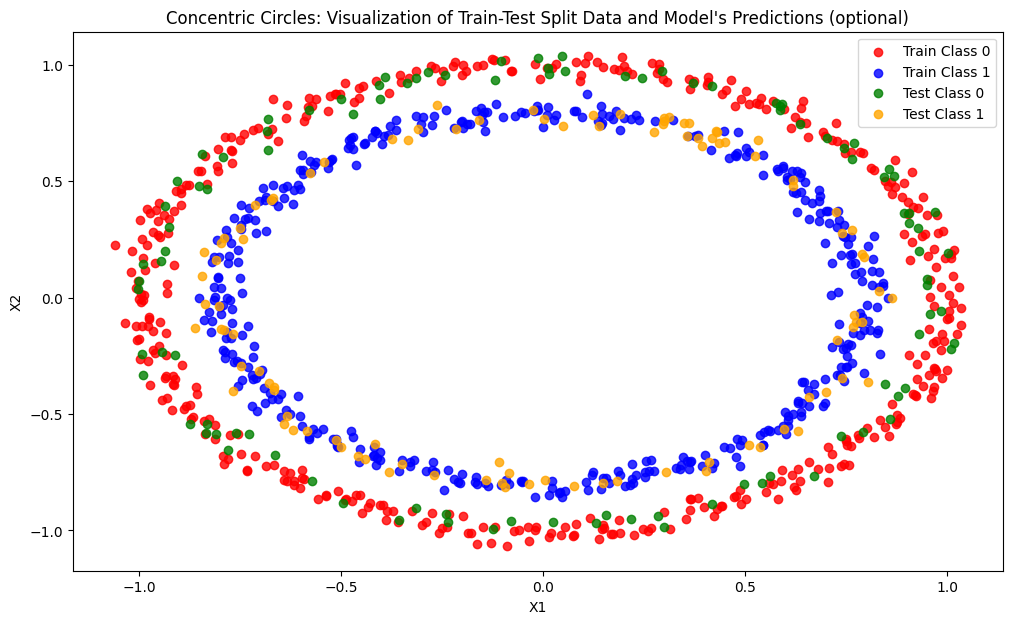

In [97]:
# plot
plot_data_preds()

Plotting the data together with model predictions seems impossible to me now but will look into it later

In [100]:
# Let's functionalize making predictions
def make_predictions(model):
    model.eval()
    with torch.inference_mode():
        model_preds = torch.round(torch.sigmoid(model(X_test.to(device))))
    return model_preds

In [101]:
make_predictions(model=model_0)[:10]

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]])

In [103]:
preds = make_predictions(model=model_0).squeeze()
preds[:10]

tensor([1., 1., 0., 1., 0., 1., 1., 1., 0., 1.])

### 3.3 Building a training and test loop


In [105]:
# Setup empty lists for logging
epoch_count = []
train_loss_values = []
test_loss_values = []

In [106]:
y_train.shape, X_train.shape, y_test.shape, X_test.shape

(torch.Size([800]),
 torch.Size([800, 2]),
 torch.Size([200]),
 torch.Size([200, 2]))

In [33]:
def train_test(
    epochs,
    model=model_0,
    train_data=X_train,
    test_data=X_test,
    train_labels=y_train,
    test_labels=y_test,
    loss_fn=loss_fn,
    optimizer=optimizer,
    plot_preds=True,
):
    # Train loop
    model.train()
    for epoch in range(epochs):
        # Forward pass
        logits = model(train_data)
        # Calculate loss
        loss = loss_fn(logits, train_labels)
        # Zero optimizer gradients
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Gradient descent
        optimizer.step

        # Test loop
        model.eval()
        with torch.inference_mode():
            test_preds = model(test_data)
        test_loss = loss_fn(test_preds, test_labels)

        # Logging
        if (epoch % 0.2) == 0:
            print(f"Epoch: {epoch} | Training Loss: {loss} | Test loss: {test_loss}")
            # logs
            epoch_count.append(epoch.item())
            train_loss_values.append(loss.item())
            test_loss_values.append(test_loss.item())

    # Visualize/plotting
    if plot_preds:
        plot_data_preds()

In [ ]:
train_test(epochs=10, plot_preds=True)

### Training the model


### Evaluate/Test the model


### Save the model
